In [18]:
%matplotlib inline
import cv2
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage.filters import correlate 
import matplotlib.pyplot as plt
import matplotlib.image as pltimg 
import math
import skimage
from scipy.ndimage.filters import gaussian_laplace
from scipy.ndimage.filters import maximum_filter
from skimage.feature import peak_local_max
from skimage.transform import resize

In [2]:
def load_image(path):
    '''
    :param path: path to load image
    :return: grayscaled and float image
    '''
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # transmit the image to float
    img = img.astype(np.float64)/255.0

    print(img.shape)
    return img

In [3]:
def normalize(img):
    ''' Function to normalize an input array to 0-1 '''
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

def generate_laplacian_filter(size, sigma):
    return gaussian_laplace(np.zeros((size,size)),sigma=sigma)

In [4]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    
    for i in range(len(cx)):
        circ = Circle((cx[i], cy[i]), rad[i], color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [33]:

def blob_detector(img, sigma, k, levels, threshold, method):
    sigma = float(sigma)
    initial_sigma = sigma
    height, width = img.shape
    
    # Increase the filter size method
    if method == 'upscale':
        print("using upscale method!")
        img_scale_space = np.zeros((height, width, levels), dtype=np.float64)
        for i in range(levels):
            img_scale_space[:, :, i] = np.power(gaussian_laplace(img, sigma=sigma) * sigma**2, 2)
            sigma = sigma * k
            
    elif method == "downsample":
        print("using downsample method!")
        # TODO: add to report: filter size shall be odd
        img_scale_space = np.zeros((height, width, levels), dtype=np.float64)
        for i in range(levels):
            new_shape = (int(height * (1.0/np.power(k, i))),int(width* (1.0/np.power(k, i))))
            img_small = resize(img, new_shape)
            print("at level %d, img_small size =%s" % (i, str(img_small.shape)))
            # temp = np.absolute(gaussian_laplace(img_copyed, sigma=sigma) * sigma**2)
            img_tmp = np.power(gaussian_laplace(img_small, sigma=sigma, truncate=0.8), 2)
            #use int to indicate new size
            img_scale_space[:, :, i] = resize(img_tmp, img.shape) 
            #use fraction of current size
            
    print("scaled image space generated!")
    
    
    '''
        Non maximum supression:
            1.first: maximum filter the image
            2.check if a position is largest
            3.filtered out non_maxmum position in img
    '''
    max_filterd_space = np.zeros(img_scale_space.shape, dtype=np.float64)

    for i in range(levels):
        max_filterd_space[:, :, i] = maximum_filter(img_scale_space[:, :, i], size=(3, 3))
       
    maxima_space = np.zeros((height, width), dtype=np.float64)
    # along with level max value
    maxima_space = np.max(max_filterd_space, axis=2)

    survive_space = np.zeros(img_scale_space.shape, dtype=np.float64)
    # locating survive pos

    for i in range(levels):
        boolean_space = (maxima_space == img_scale_space[:, :, i])
        survive_space[:, :, i] = boolean_space * img
    
    print("begin drawing circles!")

    cx = []
    cy = []
    radius = []
    for i in range(levels):
        print("num possible = %d" % (np.count_nonzero(survive_space[:, :, i])))
        location = np.argwhere(survive_space[:, :, i] >= threshold)
        # in higher scale have larger radius
        rad = np.sqrt(2) * initial_sigma * np.power(k, i)
        cx = cx + [x[0] for x in location]
        cy = cy + [x[1] for x in location]
        radius = radius + [rad]*len(location)
        print("At level %d, there are %d circles" % (i, len(location)))
        
    # with open("coor.txt","w") as fp:
    #     pos = zip(cx,cy,radius)
    #     fp.write(str([x for x in pos]))
    
    print("circle numebrs %d" %(len(cx)))
    
    # !!! Attention, cx and cy are reversed
    show_all_circles(img, cy, cx, radius)


In [34]:

BUTTERFLY = "data\\part2\\butterfly.jpg" 
EINSTEIN = "data\\part2\\einstein.jpg"
FISHES = "data\\part2\\fishes.jpg"
SUNFLOWERS =  "data\\part2\\sunflowers.jpg"

In [35]:
# upscaling parameters
'''
k           increasing factor K
levels      number of iterations
'''
threshold = 0.25
k = 1.25   
levels = 12                   
sigma = 2

img = load_image(BUTTERFLY)
blob_detector(img, sigma, k, levels, threshold, method = 'upscale')

(356, 493)
using upscale method!


scaled image space generated!
begin drawing circles!
num possible = 690
At level 0, there are 418 circles
num possible = 183
At level 1, there are 142 circles
num possible = 190
At level 2, there are 148 circles


num possible = 123
At level 3, there are 95 circles
num possible = 118
At level 4, there are 81 circles
num possible = 79
At level 5, there are 42 circles
num possible = 50
At level 6, there are 23 circles
num possible = 39
At level 7, there are 20 circles
num possible = 27
At level 8, there are 16 circles
num possible = 6
At level 9, there are 5 circles
num possible = 7
At level 10, there are 5 circles
num possible = 14
At level 11, there are 11 circles
circle numebrs 1006


using downsample method!
at level 0, img_small size =(356, 493)
at level 1, img_small size =(284, 394)
at level 2, img_small size =(227, 315)
at level 3, img_small size =(182, 252)
at level 4, img_small size =(145, 201)
at level 5, img_small size =(116, 161)
at level 6, img_small size =(93, 129)
at level 7, img_small size =(74, 103)
at level 8, img_small size =(59, 82)
at level 9, img_small size =(47, 66)


C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


at level 10, img_small size =(38, 52)
at level 11, img_small size =(30, 42)
scaled image space generated!


begin drawing circles!
num possible = 1124
At level 0, there are 1105 circles
num possible = 0
At level 1, there are 0 circles
num possible = 2
At level 2, there are 2 circles
num possible = 5
At level 3, there are 5 circles
num possible = 4
At level 4, there are 4 circles
num possible = 4
At level 5, there are 2 circles
num possible = 6
At level 6, there are 5 circles
num possible = 3
At level 7, there are 2 circles
num possible = 5
At level 8, there are 4 circles
num possible = 7
At level 9, there are 5 circles
num possible = 1
At level 10, there are 1 circles
num possible = 3
At level 11, there are 3 circles
circle numebrs 1138


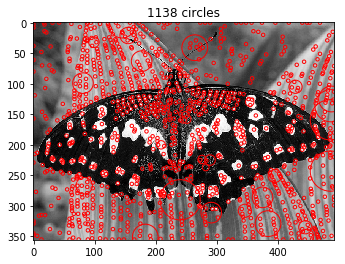

In [36]:
# img = load_image(EINSTEIN)
threshold = 0.25
k = 1.25
levels = 12                   
sigma = 2
blob_detector(img, sigma, k, levels, threshold, method = 'downsample')